In [ ]:
# Runned_by_Colab

# 2. 이번 Trial 내용
# 모델에 LSTM(units=50) 모델 한 층 더 추가(2시간 -> 5시간 50분 정도 소요되게 만드는 주 원인)
# 모델에 dropout  = 0.1 출력층을 제외한 매 레이어 이후에 추가

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Import Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Dropout, Bidirectional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Read Data
data_path = '/content/drive/MyDrive/Dacon_Data/[DACON]Bit_Trader/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [6]:
# 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 2차원 DF LSTM으로 학습하기 위해 3차원으로 변환시키기
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)   
test_x_array = df2d_to_array3d(test_x_df)    

In [7]:
def build_model():
    seq_len = 120
    model = Sequential()
    model.add(LSTM(100, activation = 'tanh', return_sequences= True, input_shape = [seq_len, 1])) 
    model.add(Dropout(0.1))
    model.add(LSTM(50, activation = 'tanh', return_sequences = True))
    model.add(Dropout(0.1))
    model.add(LSTM(50, activation = 'tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(1))  
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    return model

In [8]:
build_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 50)           10400     
_________________________________________________________________
dropout (Dropout)            (None, 120, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [9]:
# test_x_array에 대한 Auto_Regressive한 Prediction 및 valid_pred_array에 예측 결과 기록

test_pred_array = np.zeros([len(test_x_array), 120, 1])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience= 10, mode = 'auto')

ep = 30
bs = 120

# idx에 해당하는 샘플 529개 학습: for loop 529번 돌아감
for idx in tqdm(range(test_x_array.shape[0])):  # 529번
    seq_len = 120
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(test_x_array[idx, :, 1][index: index + sequence_length])

    # x_test, y_test 데이터셋 구성
    windows = np.array(windows)  # 1329 * 121의 2차원 배열
    x_test = windows[:, :-1]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = windows[:, -1]
    
    model = build_model()
    history = model.fit(x_test, y_test, epochs= ep, batch_size= bs, verbose=0, shuffle = True, callbacks=[early_stop])
    print('sample_id : ', idx, '번')
    print('loss : ', history.history['loss'][-1])

    # test_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]  # windows.shape (1259, 121), window.shape (120, )
    window_3d = np.reshape(window, (1, window.shape[0], 1))  # (1, 120, 1)
    for m in range(window.shape[0]):
        pred = model.predict(window_3d)
        test_pred_array[idx, m, :] = pred
        window_3d_2nd = window_3d[0, 1:, :]  # 119개
        pred_target = test_pred_array[idx, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

  0%|          | 0/529 [00:00<?, ?it/s]

sample_id :  0 번
loss :  0.005961648654192686


  0%|          | 1/529 [01:04<9:24:50, 64.19s/it]

sample_id :  1 번
loss :  0.006110640708357096


  0%|          | 2/529 [01:43<8:18:21, 56.74s/it]

sample_id :  2 번
loss :  0.00539400102570653


  1%|          | 3/529 [02:23<7:32:36, 51.63s/it]

sample_id :  3 번
loss :  0.006030359771102667


  1%|          | 4/529 [03:02<7:00:20, 48.04s/it]

sample_id :  4 번
loss :  0.0062986682169139385


  1%|          | 5/529 [03:43<6:38:44, 45.66s/it]

sample_id :  5 번
loss :  0.006399593316018581


  1%|          | 6/529 [04:22<6:21:57, 43.82s/it]

sample_id :  6 번
loss :  0.005640510469675064


  1%|▏         | 7/529 [05:02<6:10:34, 42.59s/it]

sample_id :  7 번
loss :  0.005684817209839821


  2%|▏         | 8/529 [05:41<6:01:45, 41.66s/it]

sample_id :  8 번
loss :  0.006110466085374355


  2%|▏         | 9/529 [06:21<5:56:05, 41.09s/it]

sample_id :  9 번
loss :  0.00694811949506402


  2%|▏         | 10/529 [07:01<5:51:48, 40.67s/it]

sample_id :  10 번
loss :  0.006865167524665594


  2%|▏         | 11/529 [07:41<5:49:27, 40.48s/it]

sample_id :  11 번
loss :  0.006755257025361061


  2%|▏         | 12/529 [08:20<5:46:30, 40.21s/it]

sample_id :  12 번
loss :  0.006154235452413559


  2%|▏         | 13/529 [09:00<5:44:30, 40.06s/it]

sample_id :  13 번
loss :  0.005737153347581625


  3%|▎         | 14/529 [09:40<5:43:03, 39.97s/it]

sample_id :  14 번
loss :  0.006753182969987392


  3%|▎         | 15/529 [10:20<5:42:14, 39.95s/it]

sample_id :  15 번
loss :  0.006787803955376148


  3%|▎         | 16/529 [11:00<5:41:40, 39.96s/it]

sample_id :  16 번
loss :  0.005599284544587135


  3%|▎         | 17/529 [11:39<5:40:05, 39.85s/it]

sample_id :  17 번
loss :  0.006761908996850252


  3%|▎         | 18/529 [12:19<5:39:48, 39.90s/it]

sample_id :  18 번
loss :  0.006821971852332354


  4%|▎         | 19/529 [12:59<5:38:57, 39.88s/it]

sample_id :  19 번
loss :  0.006243308540433645


  4%|▍         | 20/529 [13:39<5:38:31, 39.91s/it]

sample_id :  20 번
loss :  0.0066648186184465885


  4%|▍         | 21/529 [14:19<5:36:40, 39.76s/it]

sample_id :  21 번
loss :  0.006317231338471174


  4%|▍         | 22/529 [14:58<5:35:08, 39.66s/it]

sample_id :  22 번
loss :  0.006081041414290667


  4%|▍         | 23/529 [15:38<5:34:25, 39.66s/it]

sample_id :  23 번
loss :  0.007564309984445572


  5%|▍         | 24/529 [16:17<5:33:21, 39.61s/it]

sample_id :  24 번
loss :  0.007165732327848673


  5%|▍         | 25/529 [16:57<5:32:57, 39.64s/it]

sample_id :  25 번
loss :  0.008178691379725933


  5%|▍         | 26/529 [17:36<5:31:54, 39.59s/it]

sample_id :  26 번
loss :  0.008188236504793167


  5%|▌         | 27/529 [18:16<5:31:19, 39.60s/it]

sample_id :  27 번
loss :  0.005586555693298578


  5%|▌         | 28/529 [18:56<5:30:43, 39.61s/it]

sample_id :  28 번
loss :  0.006349536124616861


  5%|▌         | 29/529 [19:36<5:30:59, 39.72s/it]

sample_id :  29 번
loss :  0.006069091614335775


  6%|▌         | 30/529 [20:16<5:31:45, 39.89s/it]

sample_id :  30 번
loss :  0.006270708050578833


  6%|▌         | 31/529 [20:56<5:30:58, 39.88s/it]

sample_id :  31 번
loss :  0.006956147495657206


  6%|▌         | 32/529 [21:35<5:30:01, 39.84s/it]

sample_id :  32 번
loss :  0.007564816623926163


  6%|▌         | 33/529 [22:14<5:27:13, 39.58s/it]

sample_id :  33 번
loss :  0.00629064068198204


  6%|▋         | 34/529 [22:54<5:27:39, 39.72s/it]

sample_id :  34 번
loss :  0.006479472387582064


  7%|▋         | 35/529 [23:35<5:28:32, 39.90s/it]

sample_id :  35 번
loss :  0.006708042696118355


  7%|▋         | 36/529 [24:15<5:28:58, 40.04s/it]

sample_id :  36 번
loss :  0.006578402128070593


  7%|▋         | 37/529 [24:55<5:28:28, 40.06s/it]

sample_id :  37 번
loss :  0.006264569703489542


  7%|▋         | 38/529 [25:35<5:28:02, 40.09s/it]

sample_id :  38 번
loss :  0.006144651211798191


  7%|▋         | 39/529 [26:15<5:27:14, 40.07s/it]

sample_id :  39 번
loss :  0.006019405089318752


  8%|▊         | 40/529 [26:56<5:26:52, 40.11s/it]

sample_id :  40 번
loss :  0.0055704317055642605


  8%|▊         | 41/529 [27:36<5:26:36, 40.16s/it]

sample_id :  41 번
loss :  0.005860398523509502


  8%|▊         | 42/529 [28:16<5:25:31, 40.11s/it]

sample_id :  42 번
loss :  0.006081766914576292


  8%|▊         | 43/529 [28:55<5:23:37, 39.95s/it]

sample_id :  43 번
loss :  0.006497066468000412


  8%|▊         | 44/529 [29:35<5:22:37, 39.91s/it]

sample_id :  44 번
loss :  0.0053347330540418625


  9%|▊         | 45/529 [30:15<5:21:37, 39.87s/it]

sample_id :  45 번
loss :  0.006134468130767345


  9%|▊         | 46/529 [30:55<5:20:25, 39.80s/it]

sample_id :  46 번
loss :  0.007222192827612162


  9%|▉         | 47/529 [31:33<5:15:38, 39.29s/it]

sample_id :  47 번
loss :  0.00612054904922843


  9%|▉         | 48/529 [32:13<5:17:37, 39.62s/it]

sample_id :  48 번
loss :  0.006226822733879089


  9%|▉         | 49/529 [32:53<5:18:18, 39.79s/it]

sample_id :  49 번
loss :  0.00756628904491663


  9%|▉         | 50/529 [33:33<5:18:15, 39.86s/it]

sample_id :  50 번
loss :  0.006991561967879534


 10%|▉         | 51/529 [34:13<5:17:42, 39.88s/it]

sample_id :  51 번
loss :  0.005704883486032486


 10%|▉         | 52/529 [34:54<5:17:47, 39.97s/it]

sample_id :  52 번
loss :  0.006372617557644844


 10%|█         | 53/529 [35:34<5:17:34, 40.03s/it]

sample_id :  53 번
loss :  0.006092050578445196


 10%|█         | 54/529 [36:14<5:17:41, 40.13s/it]

sample_id :  54 번
loss :  0.0059298742562532425


 10%|█         | 55/529 [36:54<5:15:53, 39.99s/it]

sample_id :  55 번
loss :  0.005556041374802589


 11%|█         | 56/529 [37:33<5:14:22, 39.88s/it]

sample_id :  56 번
loss :  0.006152155343443155


 11%|█         | 57/529 [38:13<5:13:09, 39.81s/it]

sample_id :  57 번
loss :  0.006021243054419756


 11%|█         | 58/529 [38:53<5:13:01, 39.88s/it]

sample_id :  58 번
loss :  0.00621061073616147


 11%|█         | 59/529 [39:33<5:12:00, 39.83s/it]

sample_id :  59 번
loss :  0.006088574882596731


 11%|█▏        | 60/529 [40:12<5:10:58, 39.78s/it]

sample_id :  60 번
loss :  0.009021410718560219


 12%|█▏        | 61/529 [40:52<5:10:53, 39.86s/it]

sample_id :  61 번
loss :  0.005190538242459297


 12%|█▏        | 62/529 [41:33<5:11:07, 39.97s/it]

sample_id :  62 번
loss :  0.007189777214080095


 12%|█▏        | 63/529 [42:13<5:10:30, 39.98s/it]

sample_id :  63 번
loss :  0.004904243629425764


 12%|█▏        | 64/529 [42:53<5:10:06, 40.01s/it]

sample_id :  64 번
loss :  0.006782662123441696


 12%|█▏        | 65/529 [43:33<5:09:42, 40.05s/it]

sample_id :  65 번
loss :  0.006677236873656511


 12%|█▏        | 66/529 [44:13<5:08:15, 39.95s/it]

sample_id :  66 번
loss :  0.005206730216741562


 13%|█▎        | 67/529 [44:52<5:07:06, 39.88s/it]

sample_id :  67 번
loss :  0.006394531577825546


 13%|█▎        | 68/529 [45:32<5:05:42, 39.79s/it]

sample_id :  68 번
loss :  0.008140314370393753


 13%|█▎        | 69/529 [46:12<5:05:19, 39.82s/it]

sample_id :  69 번
loss :  0.005573635455220938


 13%|█▎        | 70/529 [46:52<5:04:32, 39.81s/it]

sample_id :  70 번
loss :  0.006370597518980503


 13%|█▎        | 71/529 [47:32<5:04:14, 39.86s/it]

sample_id :  71 번
loss :  0.006268667057156563


 14%|█▎        | 72/529 [48:11<5:03:39, 39.87s/it]

sample_id :  72 번
loss :  0.007260313257575035


 14%|█▍        | 73/529 [48:52<5:03:43, 39.96s/it]

sample_id :  73 번
loss :  0.005581267178058624


 14%|█▍        | 74/529 [49:31<5:02:44, 39.92s/it]

sample_id :  74 번
loss :  0.005921368952840567


 14%|█▍        | 75/529 [50:11<5:01:26, 39.84s/it]

sample_id :  75 번
loss :  0.00677763856947422


 14%|█▍        | 76/529 [50:51<5:00:34, 39.81s/it]

sample_id :  76 번
loss :  0.007405683398246765


 15%|█▍        | 77/529 [51:31<5:01:18, 40.00s/it]

sample_id :  77 번
loss :  0.006912542972713709


 15%|█▍        | 78/529 [52:12<5:01:14, 40.08s/it]

sample_id :  78 번
loss :  0.006387893110513687


 15%|█▍        | 79/529 [52:51<5:00:05, 40.01s/it]

sample_id :  79 번
loss :  0.007761722896248102


 15%|█▌        | 80/529 [53:31<4:59:05, 39.97s/it]

sample_id :  80 번
loss :  0.006089162081480026


 15%|█▌        | 81/529 [54:11<4:58:42, 40.01s/it]

sample_id :  81 번
loss :  0.00710675772279501


 16%|█▌        | 82/529 [54:52<4:58:54, 40.12s/it]

sample_id :  82 번
loss :  0.006209026090800762


 16%|█▌        | 83/529 [55:32<4:58:42, 40.19s/it]

sample_id :  83 번
loss :  0.005669386591762304


 16%|█▌        | 84/529 [56:12<4:58:20, 40.23s/it]

sample_id :  84 번
loss :  0.006306213326752186


 16%|█▌        | 85/529 [56:52<4:57:08, 40.15s/it]

sample_id :  85 번
loss :  0.005863170139491558


 16%|█▋        | 86/529 [57:32<4:56:02, 40.09s/it]

sample_id :  86 번
loss :  0.005794955417513847


 16%|█▋        | 87/529 [58:12<4:55:27, 40.11s/it]

sample_id :  87 번
loss :  0.005944460164755583


 17%|█▋        | 88/529 [58:52<4:53:54, 39.99s/it]

sample_id :  88 번
loss :  0.005320987664163113


 17%|█▋        | 89/529 [59:32<4:53:19, 40.00s/it]

sample_id :  89 번
loss :  0.007389094214886427


 17%|█▋        | 90/529 [1:00:12<4:52:33, 39.98s/it]

sample_id :  90 번
loss :  0.005672747734934092


 17%|█▋        | 91/529 [1:00:52<4:51:46, 39.97s/it]

sample_id :  91 번
loss :  0.00716641778126359


 17%|█▋        | 92/529 [1:01:32<4:51:35, 40.04s/it]

sample_id :  92 번
loss :  0.006273324601352215


 18%|█▊        | 93/529 [1:02:12<4:49:53, 39.89s/it]

sample_id :  93 번
loss :  0.006087573245167732


 18%|█▊        | 94/529 [1:02:51<4:48:35, 39.81s/it]

sample_id :  94 번
loss :  0.005627355072647333


 18%|█▊        | 95/529 [1:03:31<4:46:34, 39.62s/it]

sample_id :  95 번
loss :  0.006191031541675329


 18%|█▊        | 96/529 [1:04:10<4:45:09, 39.51s/it]

sample_id :  96 번
loss :  0.006244001444429159


 18%|█▊        | 97/529 [1:04:49<4:44:21, 39.49s/it]

sample_id :  97 번
loss :  0.012512127868831158


 19%|█▊        | 98/529 [1:05:29<4:43:26, 39.46s/it]

sample_id :  98 번
loss :  0.0065517243929207325


 19%|█▊        | 99/529 [1:06:08<4:42:53, 39.47s/it]

sample_id :  99 번
loss :  0.006370943505316973


 19%|█▉        | 100/529 [1:06:48<4:42:12, 39.47s/it]

sample_id :  100 번
loss :  0.008342006243765354


 19%|█▉        | 101/529 [1:07:27<4:41:07, 39.41s/it]

sample_id :  101 번
loss :  0.005855879280716181


 19%|█▉        | 102/529 [1:08:07<4:41:39, 39.58s/it]

sample_id :  102 번
loss :  0.008342989720404148


 19%|█▉        | 103/529 [1:08:47<4:41:27, 39.64s/it]

sample_id :  103 번
loss :  0.006409256719052792


 20%|█▉        | 104/529 [1:09:27<4:41:28, 39.74s/it]

sample_id :  104 번
loss :  0.00641939602792263


 20%|█▉        | 105/529 [1:10:06<4:40:41, 39.72s/it]

sample_id :  105 번
loss :  0.006460088305175304


 20%|██        | 106/529 [1:10:46<4:39:52, 39.70s/it]

sample_id :  106 번
loss :  0.005438659805804491


 20%|██        | 107/529 [1:11:25<4:38:25, 39.59s/it]

sample_id :  107 번
loss :  0.007062917109578848


 20%|██        | 108/529 [1:12:05<4:37:59, 39.62s/it]

sample_id :  108 번
loss :  0.0055069648660719395


 21%|██        | 109/529 [1:12:45<4:37:11, 39.60s/it]

sample_id :  109 번
loss :  0.0062504117377102375


 21%|██        | 110/529 [1:13:24<4:37:08, 39.69s/it]

sample_id :  110 번
loss :  0.005964934825897217


 21%|██        | 111/529 [1:14:04<4:37:01, 39.76s/it]

sample_id :  111 번
loss :  0.006717275828123093


 21%|██        | 112/529 [1:14:45<4:37:03, 39.86s/it]

sample_id :  112 번
loss :  0.007458175532519817


 21%|██▏       | 113/529 [1:15:24<4:36:19, 39.86s/it]

sample_id :  113 번
loss :  0.005801722873002291


 22%|██▏       | 114/529 [1:16:04<4:35:43, 39.86s/it]

sample_id :  114 번
loss :  0.006665677297860384


 22%|██▏       | 115/529 [1:16:45<4:36:07, 40.02s/it]

sample_id :  115 번
loss :  0.006583744194358587


 22%|██▏       | 116/529 [1:17:24<4:35:01, 39.96s/it]

sample_id :  116 번
loss :  0.005903156939893961


 22%|██▏       | 117/529 [1:18:04<4:33:59, 39.90s/it]

sample_id :  117 번
loss :  0.006203829776495695


 22%|██▏       | 118/529 [1:18:44<4:33:11, 39.88s/it]

sample_id :  118 번
loss :  0.006546847056597471


 22%|██▏       | 119/529 [1:19:24<4:32:22, 39.86s/it]

sample_id :  119 번
loss :  0.0065637752413749695


 23%|██▎       | 120/529 [1:20:03<4:30:51, 39.74s/it]

sample_id :  120 번
loss :  0.009568200446665287


 23%|██▎       | 121/529 [1:20:43<4:30:04, 39.72s/it]

sample_id :  121 번
loss :  0.005797330290079117


 23%|██▎       | 122/529 [1:21:23<4:29:03, 39.67s/it]

sample_id :  122 번
loss :  0.006645022891461849


 23%|██▎       | 123/529 [1:22:02<4:28:03, 39.62s/it]

sample_id :  123 번
loss :  0.0072925942949950695


 23%|██▎       | 124/529 [1:22:42<4:28:23, 39.76s/it]

sample_id :  124 번
loss :  0.007253648247569799


 24%|██▎       | 125/529 [1:23:22<4:28:32, 39.88s/it]

sample_id :  125 번
loss :  0.006606503389775753


 24%|██▍       | 126/529 [1:24:02<4:28:32, 39.98s/it]

sample_id :  126 번
loss :  0.006584526505321264


 24%|██▍       | 127/529 [1:24:42<4:27:06, 39.87s/it]

sample_id :  127 번
loss :  0.006249225698411465


 24%|██▍       | 128/529 [1:25:21<4:25:06, 39.67s/it]

sample_id :  128 번
loss :  0.0060152048245072365


 24%|██▍       | 129/529 [1:26:01<4:24:05, 39.61s/it]

sample_id :  129 번
loss :  0.0055872658267617226


 25%|██▍       | 130/529 [1:26:40<4:23:37, 39.64s/it]

sample_id :  130 번
loss :  0.005833819508552551


 25%|██▍       | 131/529 [1:27:20<4:23:25, 39.71s/it]

sample_id :  131 번
loss :  0.005891367327421904


 25%|██▍       | 132/529 [1:28:00<4:23:32, 39.83s/it]

sample_id :  132 번
loss :  0.0060233986005187035


 25%|██▌       | 133/529 [1:28:40<4:23:01, 39.85s/it]

sample_id :  133 번
loss :  0.005754468962550163


 25%|██▌       | 134/529 [1:29:20<4:22:01, 39.80s/it]

sample_id :  134 번
loss :  0.005983609240502119


 26%|██▌       | 135/529 [1:30:00<4:21:18, 39.79s/it]

sample_id :  135 번
loss :  0.0056573571637272835


 26%|██▌       | 136/529 [1:30:39<4:20:16, 39.74s/it]

sample_id :  136 번
loss :  0.007206049282103777


 26%|██▌       | 137/529 [1:31:19<4:19:49, 39.77s/it]

sample_id :  137 번
loss :  0.0058863479644060135


 26%|██▌       | 138/529 [1:31:59<4:19:35, 39.84s/it]

sample_id :  138 번
loss :  0.0066400798968970776


 26%|██▋       | 139/529 [1:32:39<4:19:39, 39.95s/it]

sample_id :  139 번
loss :  0.0062338123098015785


 26%|██▋       | 140/529 [1:33:19<4:18:58, 39.95s/it]

sample_id :  140 번
loss :  0.005957543384283781


 27%|██▋       | 141/529 [1:33:59<4:17:39, 39.84s/it]

sample_id :  141 번
loss :  0.006519979797303677


 27%|██▋       | 142/529 [1:34:39<4:16:33, 39.78s/it]

sample_id :  142 번
loss :  0.006566854193806648


 27%|██▋       | 143/529 [1:35:18<4:15:10, 39.66s/it]

sample_id :  143 번
loss :  0.006119461730122566


 27%|██▋       | 144/529 [1:35:57<4:13:59, 39.58s/it]

sample_id :  144 번
loss :  0.008735966868698597


 27%|██▋       | 145/529 [1:36:37<4:13:21, 39.59s/it]

sample_id :  145 번
loss :  0.00591892609372735


 28%|██▊       | 146/529 [1:37:17<4:12:33, 39.57s/it]

sample_id :  146 번
loss :  0.006146149709820747


 28%|██▊       | 147/529 [1:37:56<4:11:23, 39.49s/it]

sample_id :  147 번
loss :  0.006207308731973171


 28%|██▊       | 148/529 [1:38:35<4:10:48, 39.50s/it]

sample_id :  148 번
loss :  0.006374041549861431


 28%|██▊       | 149/529 [1:39:15<4:10:43, 39.59s/it]

sample_id :  149 번
loss :  0.007724087219685316


 28%|██▊       | 150/529 [1:39:55<4:09:53, 39.56s/it]

sample_id :  150 번
loss :  0.009067542850971222


 29%|██▊       | 151/529 [1:40:34<4:08:47, 39.49s/it]

sample_id :  151 번
loss :  0.004375484772026539


 29%|██▊       | 152/529 [1:41:14<4:08:33, 39.56s/it]

sample_id :  152 번
loss :  0.006322442553937435


 29%|██▉       | 153/529 [1:41:53<4:07:23, 39.48s/it]

sample_id :  153 번
loss :  0.006556392647325993


 29%|██▉       | 154/529 [1:42:32<4:06:38, 39.46s/it]

sample_id :  154 번
loss :  0.005910503678023815


 29%|██▉       | 155/529 [1:43:12<4:07:06, 39.64s/it]

sample_id :  155 번
loss :  0.005184028297662735


 29%|██▉       | 156/529 [1:43:53<4:07:30, 39.81s/it]

sample_id :  156 번
loss :  0.006249543745070696


 30%|██▉       | 157/529 [1:44:33<4:07:17, 39.89s/it]

sample_id :  157 번
loss :  0.007231701631098986


 30%|██▉       | 158/529 [1:45:12<4:05:59, 39.78s/it]

sample_id :  158 번
loss :  0.006516981404274702


 30%|███       | 159/529 [1:45:52<4:05:05, 39.74s/it]

sample_id :  159 번
loss :  0.0060192616656422615


 30%|███       | 160/529 [1:46:32<4:04:53, 39.82s/it]

sample_id :  160 번
loss :  0.004723503254354


 30%|███       | 161/529 [1:47:12<4:04:26, 39.86s/it]

sample_id :  161 번
loss :  0.006013789679855108


 31%|███       | 162/529 [1:47:51<4:02:46, 39.69s/it]

sample_id :  162 번
loss :  0.00571003183722496


 31%|███       | 163/529 [1:48:31<4:01:46, 39.64s/it]

sample_id :  163 번
loss :  0.005830281879752874


 31%|███       | 164/529 [1:49:10<4:00:25, 39.52s/it]

sample_id :  164 번
loss :  0.006544532719999552


 31%|███       | 165/529 [1:49:49<3:59:02, 39.40s/it]

sample_id :  165 번
loss :  0.0060768527910113335


 31%|███▏      | 166/529 [1:50:29<3:58:32, 39.43s/it]

sample_id :  166 번
loss :  0.005932575557380915


 32%|███▏      | 167/529 [1:51:08<3:58:28, 39.53s/it]

sample_id :  167 번
loss :  0.006265935488045216


 32%|███▏      | 168/529 [1:51:48<3:58:43, 39.68s/it]

sample_id :  168 번
loss :  0.007027183659374714


 32%|███▏      | 169/529 [1:52:28<3:58:20, 39.72s/it]

sample_id :  169 번
loss :  0.006348546128720045


 32%|███▏      | 170/529 [1:53:08<3:57:18, 39.66s/it]

sample_id :  170 번
loss :  0.006186658050864935


 32%|███▏      | 171/529 [1:53:47<3:56:31, 39.64s/it]

sample_id :  171 번
loss :  0.005716249812394381


 33%|███▎      | 172/529 [1:54:27<3:55:34, 39.59s/it]

sample_id :  172 번
loss :  0.006224328186362982


 33%|███▎      | 173/529 [1:55:06<3:53:33, 39.36s/it]

sample_id :  173 번
loss :  0.0059639387764036655


 33%|███▎      | 174/529 [1:55:45<3:52:40, 39.33s/it]

sample_id :  174 번
loss :  0.006209248676896095


 33%|███▎      | 175/529 [1:56:24<3:51:59, 39.32s/it]

sample_id :  175 번
loss :  0.005929007660597563


 33%|███▎      | 176/529 [1:57:03<3:51:22, 39.33s/it]

sample_id :  176 번
loss :  0.006356470286846161


 33%|███▎      | 177/529 [1:57:43<3:51:08, 39.40s/it]

sample_id :  177 번
loss :  0.005975055042654276


 34%|███▎      | 178/529 [1:58:22<3:49:47, 39.28s/it]

sample_id :  178 번
loss :  0.006546237040311098


 34%|███▍      | 179/529 [1:59:01<3:49:12, 39.29s/it]

sample_id :  179 번
loss :  0.005990646313875914


 34%|███▍      | 180/529 [1:59:41<3:48:43, 39.32s/it]

sample_id :  180 번
loss :  0.006401680875569582


 34%|███▍      | 181/529 [2:00:20<3:48:21, 39.37s/it]

sample_id :  181 번
loss :  0.006242459639906883


 34%|███▍      | 182/529 [2:01:00<3:47:49, 39.39s/it]

sample_id :  182 번
loss :  0.006411912851035595


 35%|███▍      | 183/529 [2:01:39<3:46:31, 39.28s/it]

sample_id :  183 번
loss :  0.0062832823023200035


 35%|███▍      | 184/529 [2:02:18<3:45:18, 39.18s/it]

sample_id :  184 번
loss :  0.006492555607110262


 35%|███▍      | 185/529 [2:02:57<3:44:22, 39.13s/it]

sample_id :  185 번
loss :  0.005387634504586458


 35%|███▌      | 186/529 [2:03:36<3:43:51, 39.16s/it]

sample_id :  186 번
loss :  0.006039090920239687


 35%|███▌      | 187/529 [2:04:15<3:42:58, 39.12s/it]

sample_id :  187 번
loss :  0.005977229680866003


 36%|███▌      | 188/529 [2:04:54<3:42:06, 39.08s/it]

sample_id :  188 번
loss :  0.006257007364183664


 36%|███▌      | 189/529 [2:05:33<3:41:45, 39.13s/it]

sample_id :  189 번
loss :  0.007333869114518166


 36%|███▌      | 190/529 [2:06:12<3:41:19, 39.17s/it]

sample_id :  190 번
loss :  0.0054268138483166695


 36%|███▌      | 191/529 [2:06:51<3:40:18, 39.11s/it]

sample_id :  191 번
loss :  0.006562254391610622


 36%|███▋      | 192/529 [2:07:31<3:39:45, 39.13s/it]

sample_id :  192 번
loss :  0.006296712905168533


 36%|███▋      | 193/529 [2:08:10<3:39:27, 39.19s/it]

sample_id :  193 번
loss :  0.006572131998836994


 37%|███▋      | 194/529 [2:08:49<3:38:31, 39.14s/it]

sample_id :  194 번
loss :  0.005778460763394833


 37%|███▋      | 195/529 [2:09:28<3:38:07, 39.18s/it]

sample_id :  195 번
loss :  0.006659339647740126


 37%|███▋      | 196/529 [2:10:08<3:38:00, 39.28s/it]

sample_id :  196 번
loss :  0.0060423812828958035


 37%|███▋      | 197/529 [2:10:47<3:37:56, 39.39s/it]

sample_id :  197 번
loss :  0.006481923628598452


 37%|███▋      | 198/529 [2:11:27<3:37:02, 39.34s/it]

sample_id :  198 번
loss :  0.005859586875885725


 38%|███▊      | 199/529 [2:12:06<3:36:42, 39.40s/it]

sample_id :  199 번
loss :  0.0067266011610627174


 38%|███▊      | 200/529 [2:12:46<3:36:24, 39.47s/it]

sample_id :  200 번
loss :  0.007019080221652985


 38%|███▊      | 201/529 [2:13:25<3:36:05, 39.53s/it]

sample_id :  201 번
loss :  0.0065301936119794846


 38%|███▊      | 202/529 [2:14:05<3:35:30, 39.54s/it]

sample_id :  202 번
loss :  0.005708902142941952


 38%|███▊      | 203/529 [2:14:45<3:35:00, 39.57s/it]

sample_id :  203 번
loss :  0.007347892504185438


 39%|███▊      | 204/529 [2:15:24<3:33:44, 39.46s/it]

sample_id :  204 번
loss :  0.006110383663326502


 39%|███▉      | 205/529 [2:16:03<3:32:13, 39.30s/it]

sample_id :  205 번
loss :  0.006017117761075497


 39%|███▉      | 206/529 [2:16:42<3:31:42, 39.33s/it]

sample_id :  206 번
loss :  0.0060713463462889194


 39%|███▉      | 207/529 [2:17:22<3:31:25, 39.40s/it]

sample_id :  207 번
loss :  0.00574724655598402


 39%|███▉      | 208/529 [2:18:01<3:31:19, 39.50s/it]

sample_id :  208 번
loss :  0.006974454969167709


 40%|███▉      | 209/529 [2:18:41<3:30:42, 39.51s/it]

sample_id :  209 번
loss :  0.00660708686336875


 40%|███▉      | 210/529 [2:19:20<3:29:09, 39.34s/it]

sample_id :  210 번
loss :  0.006333758123219013


 40%|███▉      | 211/529 [2:19:59<3:28:01, 39.25s/it]

sample_id :  211 번
loss :  0.006676843389868736


 40%|████      | 212/529 [2:20:38<3:27:15, 39.23s/it]

sample_id :  212 번
loss :  0.00609772652387619


 40%|████      | 213/529 [2:21:18<3:27:10, 39.34s/it]

sample_id :  213 번
loss :  0.006418571341782808


 40%|████      | 214/529 [2:21:57<3:26:29, 39.33s/it]

sample_id :  214 번
loss :  0.006026655435562134


 41%|████      | 215/529 [2:22:37<3:26:00, 39.36s/it]

sample_id :  215 번
loss :  0.005638582166284323


 41%|████      | 216/529 [2:23:16<3:25:20, 39.36s/it]

sample_id :  216 번
loss :  0.005914990324527025


 41%|████      | 217/529 [2:23:55<3:24:58, 39.42s/it]

sample_id :  217 번
loss :  0.007067177444696426


 41%|████      | 218/529 [2:24:35<3:25:10, 39.59s/it]

sample_id :  218 번
loss :  0.005927302408963442


 41%|████▏     | 219/529 [2:25:15<3:24:55, 39.66s/it]

sample_id :  219 번
loss :  0.006119574420154095


 42%|████▏     | 220/529 [2:25:53<3:21:30, 39.13s/it]

sample_id :  220 번
loss :  0.00596990343183279


 42%|████▏     | 221/529 [2:26:33<3:21:56, 39.34s/it]

sample_id :  221 번
loss :  0.006276619154959917


 42%|████▏     | 222/529 [2:27:13<3:21:57, 39.47s/it]

sample_id :  222 번
loss :  0.0062609524466097355


 42%|████▏     | 223/529 [2:27:52<3:21:23, 39.49s/it]

sample_id :  223 번
loss :  0.0072892652824521065


 42%|████▏     | 224/529 [2:28:32<3:20:57, 39.53s/it]

sample_id :  224 번
loss :  0.007163361180573702


 43%|████▎     | 225/529 [2:29:11<3:20:11, 39.51s/it]

sample_id :  225 번
loss :  0.0067886970937252045


 43%|████▎     | 226/529 [2:29:51<3:19:24, 39.49s/it]

sample_id :  226 번
loss :  0.005321699194610119


 43%|████▎     | 227/529 [2:30:30<3:19:01, 39.54s/it]

sample_id :  227 번
loss :  0.005748461931943893


 43%|████▎     | 228/529 [2:31:10<3:18:10, 39.50s/it]

sample_id :  228 번
loss :  0.007841303013265133


 43%|████▎     | 229/529 [2:31:49<3:16:43, 39.34s/it]

sample_id :  229 번
loss :  0.006079928949475288


 43%|████▎     | 230/529 [2:32:28<3:15:12, 39.17s/it]

sample_id :  230 번
loss :  0.006457666866481304


 44%|████▎     | 231/529 [2:33:06<3:13:55, 39.04s/it]

sample_id :  231 번
loss :  0.005885551683604717


 44%|████▍     | 232/529 [2:33:45<3:13:18, 39.05s/it]

sample_id :  232 번
loss :  0.00621219165623188


 44%|████▍     | 233/529 [2:34:25<3:12:57, 39.11s/it]

sample_id :  233 번
loss :  0.006883005611598492


 44%|████▍     | 234/529 [2:35:04<3:12:27, 39.14s/it]

sample_id :  234 번
loss :  0.00575287314131856


 44%|████▍     | 235/529 [2:35:43<3:11:36, 39.10s/it]

sample_id :  235 번
loss :  0.005929264705628157


 45%|████▍     | 236/529 [2:36:22<3:10:40, 39.05s/it]

sample_id :  236 번
loss :  0.006360896397382021


 45%|████▍     | 237/529 [2:37:01<3:09:50, 39.01s/it]

sample_id :  237 번
loss :  0.007034387439489365


 45%|████▍     | 238/529 [2:37:40<3:09:51, 39.14s/it]

sample_id :  238 번
loss :  0.005567234009504318


 45%|████▌     | 239/529 [2:38:19<3:09:11, 39.14s/it]

sample_id :  239 번
loss :  0.0067939418368041515


 45%|████▌     | 240/529 [2:38:58<3:08:22, 39.11s/it]

sample_id :  240 번
loss :  0.006798893213272095


 46%|████▌     | 241/529 [2:39:37<3:07:08, 38.99s/it]

sample_id :  241 번
loss :  0.006082592532038689


 46%|████▌     | 242/529 [2:40:16<3:06:21, 38.96s/it]

sample_id :  242 번
loss :  0.005834975745528936


 46%|████▌     | 243/529 [2:40:55<3:05:23, 38.89s/it]

sample_id :  243 번
loss :  0.005866224877536297


 46%|████▌     | 244/529 [2:41:34<3:05:11, 38.99s/it]

sample_id :  244 번
loss :  0.006877175997942686


 46%|████▋     | 245/529 [2:42:13<3:04:15, 38.93s/it]

sample_id :  245 번
loss :  0.008138768374919891


 47%|████▋     | 246/529 [2:42:51<3:03:20, 38.87s/it]

sample_id :  246 번
loss :  0.006395712494850159


 47%|████▋     | 247/529 [2:43:30<3:02:45, 38.89s/it]

sample_id :  247 번
loss :  0.005228410940617323


 47%|████▋     | 248/529 [2:44:10<3:02:35, 38.99s/it]

sample_id :  248 번
loss :  0.005441117100417614


 47%|████▋     | 249/529 [2:44:48<3:01:37, 38.92s/it]

sample_id :  249 번
loss :  0.0059725018218159676


 47%|████▋     | 250/529 [2:45:28<3:02:02, 39.15s/it]

sample_id :  250 번
loss :  0.006943431682884693


 47%|████▋     | 251/529 [2:46:07<3:01:38, 39.20s/it]

sample_id :  251 번
loss :  0.0062419637106359005


 48%|████▊     | 252/529 [2:46:46<3:00:50, 39.17s/it]

sample_id :  252 번
loss :  0.005347864702343941


 48%|████▊     | 253/529 [2:47:26<3:00:05, 39.15s/it]

sample_id :  253 번
loss :  0.005053551401942968


 48%|████▊     | 254/529 [2:48:05<2:59:37, 39.19s/it]

sample_id :  254 번
loss :  0.005956354085355997


 48%|████▊     | 255/529 [2:48:45<3:00:11, 39.46s/it]

sample_id :  255 번
loss :  0.006082641426473856


 48%|████▊     | 256/529 [2:49:25<2:59:59, 39.56s/it]

sample_id :  256 번
loss :  0.006940681021660566


 49%|████▊     | 257/529 [2:50:04<2:59:37, 39.62s/it]

sample_id :  257 번
loss :  0.00563263101503253


 49%|████▉     | 258/529 [2:50:45<2:59:35, 39.76s/it]

sample_id :  258 번
loss :  0.008034883067011833


 49%|████▉     | 259/529 [2:51:24<2:58:36, 39.69s/it]

sample_id :  259 번
loss :  0.003941443283110857


 49%|████▉     | 260/529 [2:52:04<2:57:37, 39.62s/it]

sample_id :  260 번
loss :  0.006301003508269787


 49%|████▉     | 261/529 [2:52:43<2:56:57, 39.62s/it]

sample_id :  261 번
loss :  0.006885174661874771


 50%|████▉     | 262/529 [2:53:23<2:56:10, 39.59s/it]

sample_id :  262 번
loss :  0.007332539651542902


 50%|████▉     | 263/529 [2:54:02<2:55:16, 39.54s/it]

sample_id :  263 번
loss :  0.006033382378518581


 50%|████▉     | 264/529 [2:54:42<2:54:36, 39.54s/it]

sample_id :  264 번
loss :  0.006382943131029606


 50%|█████     | 265/529 [2:55:21<2:53:45, 39.49s/it]

sample_id :  265 번
loss :  0.0064163836650550365


 50%|█████     | 266/529 [2:56:01<2:53:14, 39.52s/it]

sample_id :  266 번
loss :  0.006780627649277449


 50%|█████     | 267/529 [2:56:40<2:52:44, 39.56s/it]

sample_id :  267 번
loss :  0.006443079560995102


 51%|█████     | 268/529 [2:57:20<2:52:10, 39.58s/it]

sample_id :  268 번
loss :  0.006321070250123739


 51%|█████     | 269/529 [2:57:59<2:51:05, 39.48s/it]

sample_id :  269 번
loss :  0.005584481172263622


 51%|█████     | 270/529 [2:58:39<2:50:44, 39.56s/it]

sample_id :  270 번
loss :  0.005849458742886782


 51%|█████     | 271/529 [2:59:19<2:50:31, 39.66s/it]

sample_id :  271 번
loss :  0.006175154820084572


 51%|█████▏    | 272/529 [2:59:58<2:49:33, 39.59s/it]

sample_id :  272 번
loss :  0.0059120687656104565


 52%|█████▏    | 273/529 [3:00:38<2:49:05, 39.63s/it]

sample_id :  273 번
loss :  0.005686177872121334


 52%|█████▏    | 274/529 [3:01:18<2:48:43, 39.70s/it]

sample_id :  274 번
loss :  0.005585044622421265


 52%|█████▏    | 275/529 [3:01:57<2:47:31, 39.57s/it]

sample_id :  275 번
loss :  0.00606958381831646


 52%|█████▏    | 276/529 [3:02:36<2:46:36, 39.51s/it]

sample_id :  276 번
loss :  0.006243822630494833


 52%|█████▏    | 277/529 [3:03:16<2:45:59, 39.52s/it]

sample_id :  277 번
loss :  0.006186036858707666


 53%|█████▎    | 278/529 [3:03:56<2:45:54, 39.66s/it]

sample_id :  278 번
loss :  0.005142004229128361


 53%|█████▎    | 279/529 [3:04:35<2:44:57, 39.59s/it]

sample_id :  279 번
loss :  0.005392058752477169


 53%|█████▎    | 280/529 [3:05:15<2:44:27, 39.63s/it]

sample_id :  280 번
loss :  0.006672451738268137


 53%|█████▎    | 281/529 [3:05:55<2:43:46, 39.62s/it]

sample_id :  281 번
loss :  0.006430028472095728


 53%|█████▎    | 282/529 [3:06:34<2:43:05, 39.62s/it]

sample_id :  282 번
loss :  0.005883616395294666


 53%|█████▎    | 283/529 [3:07:14<2:42:26, 39.62s/it]

sample_id :  283 번
loss :  0.006860803347080946


 54%|█████▎    | 284/529 [3:07:54<2:41:55, 39.66s/it]

sample_id :  284 번
loss :  0.005785985849797726


 54%|█████▍    | 285/529 [3:08:34<2:41:35, 39.74s/it]

sample_id :  285 번
loss :  0.006197808776050806


 54%|█████▍    | 286/529 [3:09:14<2:41:08, 39.79s/it]

sample_id :  286 번
loss :  0.005328711587935686


 54%|█████▍    | 287/529 [3:09:53<2:40:16, 39.74s/it]

sample_id :  287 번
loss :  0.005689062178134918


 54%|█████▍    | 288/529 [3:10:33<2:40:03, 39.85s/it]

sample_id :  288 번
loss :  0.004893665201961994


 55%|█████▍    | 289/529 [3:11:13<2:39:04, 39.77s/it]

sample_id :  289 번
loss :  0.00881943292915821


 55%|█████▍    | 290/529 [3:11:52<2:38:00, 39.67s/it]

sample_id :  290 번
loss :  0.006194247864186764


 55%|█████▌    | 291/529 [3:12:32<2:37:10, 39.62s/it]

sample_id :  291 번
loss :  0.0053858463652431965


 55%|█████▌    | 292/529 [3:13:11<2:36:11, 39.54s/it]

sample_id :  292 번
loss :  0.007385105360299349


 55%|█████▌    | 293/529 [3:13:51<2:35:49, 39.62s/it]

sample_id :  293 번
loss :  0.0062340740114450455


 56%|█████▌    | 294/529 [3:14:31<2:35:28, 39.69s/it]

sample_id :  294 번
loss :  0.005904458463191986


 56%|█████▌    | 295/529 [3:15:11<2:34:58, 39.74s/it]

sample_id :  295 번
loss :  0.0061562033370137215


 56%|█████▌    | 296/529 [3:15:50<2:34:17, 39.73s/it]

sample_id :  296 번
loss :  0.005895896349102259


 56%|█████▌    | 297/529 [3:16:30<2:32:59, 39.57s/it]

sample_id :  297 번
loss :  0.0059984298422932625


 56%|█████▋    | 298/529 [3:17:09<2:32:04, 39.50s/it]

sample_id :  298 번
loss :  0.005981858354061842


 57%|█████▋    | 299/529 [3:17:48<2:31:15, 39.46s/it]

sample_id :  299 번
loss :  0.007823909632861614


 57%|█████▋    | 300/529 [3:18:28<2:30:47, 39.51s/it]

sample_id :  300 번
loss :  0.006837083026766777


 57%|█████▋    | 301/529 [3:19:08<2:30:16, 39.55s/it]

sample_id :  301 번
loss :  0.006528524216264486


 57%|█████▋    | 302/529 [3:19:47<2:29:37, 39.55s/it]

sample_id :  302 번
loss :  0.006701793055981398


 57%|█████▋    | 303/529 [3:20:26<2:28:49, 39.51s/it]

sample_id :  303 번
loss :  0.0066947415471076965


 57%|█████▋    | 304/529 [3:21:06<2:28:16, 39.54s/it]

sample_id :  304 번
loss :  0.00621436582878232


 58%|█████▊    | 305/529 [3:21:46<2:27:48, 39.59s/it]

sample_id :  305 번
loss :  0.005902073811739683


 58%|█████▊    | 306/529 [3:22:25<2:27:14, 39.62s/it]

sample_id :  306 번
loss :  0.006699983961880207


 58%|█████▊    | 307/529 [3:23:06<2:27:06, 39.76s/it]

sample_id :  307 번
loss :  0.007755808066576719


 58%|█████▊    | 308/529 [3:23:45<2:26:30, 39.78s/it]

sample_id :  308 번
loss :  0.006143398582935333


 58%|█████▊    | 309/529 [3:24:25<2:25:27, 39.67s/it]

sample_id :  309 번
loss :  0.006800297647714615


 59%|█████▊    | 310/529 [3:25:04<2:24:29, 39.59s/it]

sample_id :  310 번
loss :  0.006053860764950514


 59%|█████▉    | 311/529 [3:25:44<2:23:48, 39.58s/it]

sample_id :  311 번
loss :  0.006559543311595917


 59%|█████▉    | 312/529 [3:26:23<2:23:15, 39.61s/it]

sample_id :  312 번
loss :  0.006575163919478655


 59%|█████▉    | 313/529 [3:27:03<2:22:18, 39.53s/it]

sample_id :  313 번
loss :  0.0063646528869867325


 59%|█████▉    | 314/529 [3:27:42<2:21:39, 39.53s/it]

sample_id :  314 번
loss :  0.005713411141186953


 60%|█████▉    | 315/529 [3:28:22<2:21:02, 39.54s/it]

sample_id :  315 번
loss :  0.006126591470092535


 60%|█████▉    | 316/529 [3:29:01<2:20:08, 39.48s/it]

sample_id :  316 번
loss :  0.005635502748191357


 60%|█████▉    | 317/529 [3:29:41<2:19:40, 39.53s/it]

sample_id :  317 번
loss :  0.006222746800631285


 60%|██████    | 318/529 [3:30:20<2:18:55, 39.51s/it]

sample_id :  318 번
loss :  0.006293762940913439


 60%|██████    | 319/529 [3:31:00<2:18:19, 39.52s/it]

sample_id :  319 번
loss :  0.005638575181365013


 60%|██████    | 320/529 [3:31:40<2:17:49, 39.57s/it]

sample_id :  320 번
loss :  0.0057065971195697784


 61%|██████    | 321/529 [3:32:19<2:17:10, 39.57s/it]

sample_id :  321 번
loss :  0.00645846500992775


 61%|██████    | 322/529 [3:32:59<2:16:20, 39.52s/it]

sample_id :  322 번
loss :  0.005167843773961067


 61%|██████    | 323/529 [3:33:38<2:15:43, 39.53s/it]

sample_id :  323 번
loss :  0.006320609711110592


 61%|██████    | 324/529 [3:34:18<2:15:20, 39.61s/it]

sample_id :  324 번
loss :  0.007048082072287798


 61%|██████▏   | 325/529 [3:34:57<2:14:24, 39.53s/it]

sample_id :  325 번
loss :  0.007723403163254261


 62%|██████▏   | 326/529 [3:35:37<2:13:51, 39.57s/it]

sample_id :  326 번
loss :  0.006484542042016983


 62%|██████▏   | 327/529 [3:36:16<2:12:57, 39.49s/it]

sample_id :  327 번
loss :  0.005930211395025253


 62%|██████▏   | 328/529 [3:36:56<2:12:26, 39.53s/it]

sample_id :  328 번
loss :  0.00546607468277216


 62%|██████▏   | 329/529 [3:37:35<2:11:37, 39.49s/it]

sample_id :  329 번
loss :  0.006902499124407768


 62%|██████▏   | 330/529 [3:38:15<2:10:53, 39.46s/it]

sample_id :  330 번
loss :  0.005451102275401354


 63%|██████▎   | 331/529 [3:38:54<2:10:25, 39.52s/it]

sample_id :  331 번
loss :  0.005896280519664288


 63%|██████▎   | 332/529 [3:39:34<2:09:44, 39.52s/it]

sample_id :  332 번
loss :  0.006772072520107031


 63%|██████▎   | 333/529 [3:40:13<2:08:54, 39.46s/it]

sample_id :  333 번
loss :  0.006169175263494253


 63%|██████▎   | 334/529 [3:40:52<2:08:01, 39.39s/it]

sample_id :  334 번
loss :  0.006153022404760122


 63%|██████▎   | 335/529 [3:41:32<2:07:14, 39.35s/it]

sample_id :  335 번
loss :  0.006445804610848427


 64%|██████▎   | 336/529 [3:42:11<2:06:31, 39.33s/it]

sample_id :  336 번
loss :  0.0068130032159388065


 64%|██████▎   | 337/529 [3:42:50<2:05:54, 39.35s/it]

sample_id :  337 번
loss :  0.005885894410312176


 64%|██████▍   | 338/529 [3:43:29<2:04:47, 39.20s/it]

sample_id :  338 번
loss :  0.006046248134225607


 64%|██████▍   | 339/529 [3:44:08<2:03:54, 39.13s/it]

sample_id :  339 번
loss :  0.007731323130428791


 64%|██████▍   | 340/529 [3:44:47<2:03:07, 39.09s/it]

sample_id :  340 번
loss :  0.00620961282402277


 64%|██████▍   | 341/529 [3:45:26<2:02:40, 39.15s/it]

sample_id :  341 번
loss :  0.006160445045679808


 65%|██████▍   | 342/529 [3:46:06<2:02:24, 39.27s/it]

sample_id :  342 번
loss :  0.00687709916383028


 65%|██████▍   | 343/529 [3:46:45<2:01:58, 39.35s/it]

sample_id :  343 번
loss :  0.006045897491276264


 65%|██████▌   | 344/529 [3:47:24<2:00:46, 39.17s/it]

sample_id :  344 번
loss :  0.005612124688923359


 65%|██████▌   | 345/529 [3:48:03<1:59:49, 39.07s/it]

sample_id :  345 번
loss :  0.0066275689750909805


 65%|██████▌   | 346/529 [3:48:42<1:59:21, 39.13s/it]

sample_id :  346 번
loss :  0.006543034687638283


 66%|██████▌   | 347/529 [3:49:22<1:58:58, 39.22s/it]

sample_id :  347 번
loss :  0.006819429807364941


 66%|██████▌   | 348/529 [3:50:00<1:57:48, 39.05s/it]

sample_id :  348 번
loss :  0.0063105495646595955


 66%|██████▌   | 349/529 [3:50:39<1:57:02, 39.01s/it]

sample_id :  349 번
loss :  0.006463721394538879


 66%|██████▌   | 350/529 [3:51:19<1:56:32, 39.06s/it]

sample_id :  350 번
loss :  0.006227211561053991


 66%|██████▋   | 351/529 [3:51:57<1:55:45, 39.02s/it]

sample_id :  351 번
loss :  0.007797585800290108


 67%|██████▋   | 352/529 [3:52:37<1:55:11, 39.05s/it]

sample_id :  352 번
loss :  0.00603523338213563


 67%|██████▋   | 353/529 [3:53:16<1:54:38, 39.09s/it]

sample_id :  353 번
loss :  0.007361211348325014


 67%|██████▋   | 354/529 [3:53:55<1:53:56, 39.07s/it]

sample_id :  354 번
loss :  0.006846209056675434


 67%|██████▋   | 355/529 [3:54:34<1:53:08, 39.01s/it]

sample_id :  355 번
loss :  0.005707622971385717


 67%|██████▋   | 356/529 [3:55:12<1:52:17, 38.95s/it]

sample_id :  356 번
loss :  0.005388271063566208


 67%|██████▋   | 357/529 [3:55:52<1:51:58, 39.06s/it]

sample_id :  357 번
loss :  0.0054602897725999355


 68%|██████▊   | 358/529 [3:56:31<1:51:24, 39.09s/it]

sample_id :  358 번
loss :  0.006081797182559967


 68%|██████▊   | 359/529 [3:57:10<1:50:39, 39.06s/it]

sample_id :  359 번
loss :  0.007048469968140125


 68%|██████▊   | 360/529 [3:57:49<1:49:42, 38.95s/it]

sample_id :  360 번
loss :  0.0057456279173493385


 68%|██████▊   | 361/529 [3:58:27<1:48:54, 38.90s/it]

sample_id :  361 번
loss :  0.006071912124752998


 68%|██████▊   | 362/529 [3:59:06<1:48:15, 38.90s/it]

sample_id :  362 번
loss :  0.004909028764814138


 69%|██████▊   | 363/529 [3:59:46<1:48:05, 39.07s/it]

sample_id :  363 번
loss :  0.007660989183932543


 69%|██████▉   | 364/529 [4:00:25<1:47:26, 39.07s/it]

sample_id :  364 번
loss :  0.005863864906132221


 69%|██████▉   | 365/529 [4:01:04<1:46:58, 39.14s/it]

sample_id :  365 번
loss :  0.006563481874763966


 69%|██████▉   | 366/529 [4:01:44<1:46:40, 39.27s/it]

sample_id :  366 번
loss :  0.006797026842832565


 69%|██████▉   | 367/529 [4:02:23<1:46:02, 39.28s/it]

sample_id :  367 번
loss :  0.006072798743844032


 70%|██████▉   | 368/529 [4:03:03<1:45:43, 39.40s/it]

sample_id :  368 번
loss :  0.006230241619050503


 70%|██████▉   | 369/529 [4:03:42<1:45:16, 39.48s/it]

sample_id :  369 번
loss :  0.007128469180315733


 70%|██████▉   | 370/529 [4:04:22<1:44:49, 39.56s/it]

sample_id :  370 번
loss :  0.006169372703880072


 70%|███████   | 371/529 [4:05:02<1:44:25, 39.65s/it]

sample_id :  371 번
loss :  0.007229659706354141


 70%|███████   | 372/529 [4:05:42<1:43:45, 39.65s/it]

sample_id :  372 번
loss :  0.006774728652089834


 71%|███████   | 373/529 [4:06:21<1:43:11, 39.69s/it]

sample_id :  373 번
loss :  0.00655418261885643


 71%|███████   | 374/529 [4:07:01<1:42:31, 39.69s/it]

sample_id :  374 번
loss :  0.005895113106817007


 71%|███████   | 375/529 [4:07:41<1:42:08, 39.80s/it]

sample_id :  375 번
loss :  0.0066374074667692184


 71%|███████   | 376/529 [4:08:21<1:41:16, 39.71s/it]

sample_id :  376 번
loss :  0.006445067934691906


 71%|███████▏  | 377/529 [4:09:00<1:40:27, 39.65s/it]

sample_id :  377 번
loss :  0.006526092533022165


 71%|███████▏  | 378/529 [4:09:40<1:39:50, 39.67s/it]

sample_id :  378 번
loss :  0.006724861450493336


 72%|███████▏  | 379/529 [4:10:20<1:39:11, 39.68s/it]

sample_id :  379 번
loss :  0.005964126903563738


 72%|███████▏  | 380/529 [4:10:59<1:38:20, 39.60s/it]

sample_id :  380 번
loss :  0.007156006991863251


 72%|███████▏  | 381/529 [4:11:39<1:37:48, 39.65s/it]

sample_id :  381 번
loss :  0.0078100054524838924


 72%|███████▏  | 382/529 [4:12:18<1:37:05, 39.63s/it]

sample_id :  382 번
loss :  0.005465222522616386


 72%|███████▏  | 383/529 [4:12:58<1:36:13, 39.54s/it]

sample_id :  383 번
loss :  0.006862305570393801


 73%|███████▎  | 384/529 [4:13:37<1:35:35, 39.55s/it]

sample_id :  384 번
loss :  0.006420809775590897


 73%|███████▎  | 385/529 [4:14:17<1:34:47, 39.49s/it]

sample_id :  385 번
loss :  0.00675877695903182


 73%|███████▎  | 386/529 [4:14:56<1:34:08, 39.50s/it]

sample_id :  386 번
loss :  0.006513317581266165


 73%|███████▎  | 387/529 [4:15:36<1:33:26, 39.48s/it]

sample_id :  387 번
loss :  0.006104988045990467


 73%|███████▎  | 388/529 [4:16:15<1:32:50, 39.51s/it]

sample_id :  388 번
loss :  0.0058000097051262856


 74%|███████▎  | 389/529 [4:16:55<1:32:22, 39.59s/it]

sample_id :  389 번
loss :  0.006520237773656845


 74%|███████▎  | 390/529 [4:17:34<1:31:19, 39.42s/it]

sample_id :  390 번
loss :  0.006733613088726997


 74%|███████▍  | 391/529 [4:18:13<1:30:39, 39.42s/it]

sample_id :  391 번
loss :  0.007732560392469168


 74%|███████▍  | 392/529 [4:18:53<1:29:51, 39.35s/it]

sample_id :  392 번
loss :  0.005386055912822485


 74%|███████▍  | 393/529 [4:19:32<1:29:15, 39.38s/it]

sample_id :  393 번
loss :  0.006517122499644756


 74%|███████▍  | 394/529 [4:20:12<1:28:51, 39.49s/it]

sample_id :  394 번
loss :  0.006502449978142977


 75%|███████▍  | 395/529 [4:20:51<1:28:18, 39.54s/it]

sample_id :  395 번
loss :  0.006500508636236191


 75%|███████▍  | 396/529 [4:21:31<1:27:41, 39.56s/it]

sample_id :  396 번
loss :  0.006242852192372084


 75%|███████▌  | 397/529 [4:22:11<1:27:02, 39.57s/it]

sample_id :  397 번
loss :  0.006751589942723513


 75%|███████▌  | 398/529 [4:22:50<1:26:24, 39.58s/it]

sample_id :  398 번
loss :  0.006693452131003141


 75%|███████▌  | 399/529 [4:23:30<1:25:49, 39.61s/it]

sample_id :  399 번
loss :  0.005226507317274809


 76%|███████▌  | 400/529 [4:24:09<1:24:54, 39.49s/it]

sample_id :  400 번
loss :  0.0053521571680903435


 76%|███████▌  | 401/529 [4:24:49<1:24:18, 39.52s/it]

sample_id :  401 번
loss :  0.0075128888711333275


 76%|███████▌  | 402/529 [4:25:28<1:23:32, 39.47s/it]

sample_id :  402 번
loss :  0.006928186397999525


 76%|███████▌  | 403/529 [4:26:06<1:21:50, 38.97s/it]

sample_id :  403 번
loss :  0.006874024402350187


 76%|███████▋  | 404/529 [4:26:45<1:21:28, 39.11s/it]

sample_id :  404 번
loss :  0.006157961208373308


 77%|███████▋  | 405/529 [4:27:25<1:21:11, 39.29s/it]

sample_id :  405 번
loss :  0.0049837492406368256


 77%|███████▋  | 406/529 [4:28:05<1:20:53, 39.46s/it]

sample_id :  406 번
loss :  0.006640100851655006


 77%|███████▋  | 407/529 [4:28:45<1:20:32, 39.61s/it]

sample_id :  407 번
loss :  0.006679864600300789


 77%|███████▋  | 408/529 [4:29:25<1:20:00, 39.67s/it]

sample_id :  408 번
loss :  0.008700409904122353


 77%|███████▋  | 409/529 [4:30:04<1:19:24, 39.70s/it]

sample_id :  409 번
loss :  0.006323580630123615


 78%|███████▊  | 410/529 [4:30:44<1:18:38, 39.66s/it]

sample_id :  410 번
loss :  0.005799255799502134


 78%|███████▊  | 411/529 [4:31:23<1:17:51, 39.59s/it]

sample_id :  411 번
loss :  0.00834377110004425


 78%|███████▊  | 412/529 [4:32:03<1:17:11, 39.59s/it]

sample_id :  412 번
loss :  0.007266615051776171


 78%|███████▊  | 413/529 [4:32:43<1:16:47, 39.72s/it]

sample_id :  413 번
loss :  0.006612459663301706


 78%|███████▊  | 414/529 [4:33:23<1:16:10, 39.75s/it]

sample_id :  414 번
loss :  0.006127316039055586


 78%|███████▊  | 415/529 [4:34:02<1:15:23, 39.68s/it]

sample_id :  415 번
loss :  0.006635703612118959


 79%|███████▊  | 416/529 [4:34:42<1:14:47, 39.71s/it]

sample_id :  416 번
loss :  0.00707531813532114


 79%|███████▉  | 417/529 [4:35:22<1:14:10, 39.74s/it]

sample_id :  417 번
loss :  0.00783329177647829


 79%|███████▉  | 418/529 [4:36:02<1:13:33, 39.76s/it]

sample_id :  418 번
loss :  0.005512679927051067


 79%|███████▉  | 419/529 [4:36:41<1:12:49, 39.72s/it]

sample_id :  419 번
loss :  0.006633371580392122


 79%|███████▉  | 420/529 [4:37:21<1:12:09, 39.72s/it]

sample_id :  420 번
loss :  0.005317909177392721


 80%|███████▉  | 421/529 [4:38:01<1:11:27, 39.70s/it]

sample_id :  421 번
loss :  0.007100897841155529


 80%|███████▉  | 422/529 [4:38:40<1:10:28, 39.52s/it]

sample_id :  422 번
loss :  0.0048143002204597


 80%|███████▉  | 423/529 [4:39:19<1:09:44, 39.47s/it]

sample_id :  423 번
loss :  0.00592292845249176


 80%|████████  | 424/529 [4:39:59<1:09:18, 39.61s/it]

sample_id :  424 번
loss :  0.007241053506731987


 80%|████████  | 425/529 [4:40:39<1:08:52, 39.74s/it]

sample_id :  425 번
loss :  0.006006275303661823


 81%|████████  | 426/529 [4:41:19<1:08:20, 39.81s/it]

sample_id :  426 번
loss :  0.006133796647191048


 81%|████████  | 427/529 [4:41:58<1:07:26, 39.68s/it]

sample_id :  427 번
loss :  0.007622594479471445


 81%|████████  | 428/529 [4:42:38<1:06:48, 39.69s/it]

sample_id :  428 번
loss :  0.008523880504071712


 81%|████████  | 429/529 [4:43:18<1:06:07, 39.68s/it]

sample_id :  429 번
loss :  0.006340601947158575


 81%|████████▏ | 430/529 [4:43:57<1:05:21, 39.61s/it]

sample_id :  430 번
loss :  0.006597256287932396


 81%|████████▏ | 431/529 [4:44:37<1:04:42, 39.62s/it]

sample_id :  431 번
loss :  0.008014417253434658


 82%|████████▏ | 432/529 [4:45:16<1:03:55, 39.54s/it]

sample_id :  432 번
loss :  0.006453762762248516


 82%|████████▏ | 433/529 [4:45:56<1:03:10, 39.48s/it]

sample_id :  433 번
loss :  0.006765200290828943


 82%|████████▏ | 434/529 [4:46:35<1:02:35, 39.54s/it]

sample_id :  434 번
loss :  0.006788432598114014


 82%|████████▏ | 435/529 [4:47:15<1:01:48, 39.45s/it]

sample_id :  435 번
loss :  0.006563729140907526


 82%|████████▏ | 436/529 [4:47:54<1:01:07, 39.43s/it]

sample_id :  436 번
loss :  0.006178665440529585


 83%|████████▎ | 437/529 [4:48:33<1:00:30, 39.46s/it]

sample_id :  437 번
loss :  0.00533726392313838


 83%|████████▎ | 438/529 [4:49:13<59:47, 39.42s/it]  

sample_id :  438 번
loss :  0.006994667928665876


 83%|████████▎ | 439/529 [4:49:52<59:03, 39.37s/it]

sample_id :  439 번
loss :  0.006331122945994139


 83%|████████▎ | 440/529 [4:50:31<58:23, 39.36s/it]

sample_id :  440 번
loss :  0.005085160955786705


 83%|████████▎ | 441/529 [4:51:11<57:50, 39.44s/it]

sample_id :  441 번
loss :  0.007232361473143101


 84%|████████▎ | 442/529 [4:51:50<57:07, 39.39s/it]

sample_id :  442 번
loss :  0.005718666594475508


 84%|████████▎ | 443/529 [4:52:30<56:28, 39.40s/it]

sample_id :  443 번
loss :  0.006764483172446489


 84%|████████▍ | 444/529 [4:53:09<55:51, 39.43s/it]

sample_id :  444 번
loss :  0.00655366200953722


 84%|████████▍ | 445/529 [4:53:49<55:09, 39.39s/it]

sample_id :  445 번
loss :  0.006318779196590185


 84%|████████▍ | 446/529 [4:54:28<54:32, 39.43s/it]

sample_id :  446 번
loss :  0.008223374374210835


 84%|████████▍ | 447/529 [4:55:08<53:57, 39.48s/it]

sample_id :  447 번
loss :  0.0066884285770356655


 85%|████████▍ | 448/529 [4:55:47<53:22, 39.54s/it]

sample_id :  448 번
loss :  0.005655849818140268


 85%|████████▍ | 449/529 [4:56:27<52:48, 39.61s/it]

sample_id :  449 번
loss :  0.007492168340831995


 85%|████████▌ | 450/529 [4:57:07<52:18, 39.73s/it]

sample_id :  450 번
loss :  0.00590492133051157


 85%|████████▌ | 451/529 [4:57:47<51:41, 39.76s/it]

sample_id :  451 번
loss :  0.008818044327199459


 85%|████████▌ | 452/529 [4:58:26<50:56, 39.70s/it]

sample_id :  452 번
loss :  0.006427065934985876


 86%|████████▌ | 453/529 [4:59:06<50:10, 39.62s/it]

sample_id :  453 번
loss :  0.0057139224372804165


 86%|████████▌ | 454/529 [4:59:46<49:43, 39.78s/it]

sample_id :  454 번
loss :  0.00696418434381485


 86%|████████▌ | 455/529 [5:00:26<49:03, 39.77s/it]

sample_id :  455 번
loss :  0.0057602920569479465


 86%|████████▌ | 456/529 [5:01:05<48:17, 39.69s/it]

sample_id :  456 번
loss :  0.006205169018357992


 86%|████████▋ | 457/529 [5:01:45<47:38, 39.70s/it]

sample_id :  457 번
loss :  0.007058133836835623


 87%|████████▋ | 458/529 [5:02:25<46:58, 39.69s/it]

sample_id :  458 번
loss :  0.005781799554824829


 87%|████████▋ | 459/529 [5:03:04<46:17, 39.68s/it]

sample_id :  459 번
loss :  0.006160259712487459


 87%|████████▋ | 460/529 [5:03:44<45:40, 39.72s/it]

sample_id :  460 번
loss :  0.006666172761470079


 87%|████████▋ | 461/529 [5:04:24<45:00, 39.71s/it]

sample_id :  461 번
loss :  0.006183049641549587


 87%|████████▋ | 462/529 [5:05:04<44:23, 39.76s/it]

sample_id :  462 번
loss :  0.005196040030568838


 88%|████████▊ | 463/529 [5:05:43<43:43, 39.75s/it]

sample_id :  463 번
loss :  0.00763709144666791


 88%|████████▊ | 464/529 [5:06:24<43:10, 39.86s/it]

sample_id :  464 번
loss :  0.006830117665231228


 88%|████████▊ | 465/529 [5:07:03<42:32, 39.88s/it]

sample_id :  465 번
loss :  0.0068703750148415565


 88%|████████▊ | 466/529 [5:07:43<41:54, 39.91s/it]

sample_id :  466 번
loss :  0.007662156596779823


 88%|████████▊ | 467/529 [5:08:24<41:22, 40.04s/it]

sample_id :  467 번
loss :  0.006515102926641703


 88%|████████▊ | 468/529 [5:09:04<40:41, 40.03s/it]

sample_id :  468 번
loss :  0.00618060352280736


 89%|████████▊ | 469/529 [5:09:44<39:57, 39.96s/it]

sample_id :  469 번
loss :  0.005774232093244791


 89%|████████▉ | 470/529 [5:10:24<39:18, 39.98s/it]

sample_id :  470 번
loss :  0.006493930704891682


 89%|████████▉ | 471/529 [5:11:04<38:38, 39.97s/it]

sample_id :  471 번
loss :  0.005525807850062847


 89%|████████▉ | 472/529 [5:11:44<37:58, 39.97s/it]

sample_id :  472 번
loss :  0.0071561760269105434


 89%|████████▉ | 473/529 [5:12:23<37:18, 39.96s/it]

sample_id :  473 번
loss :  0.006431080400943756


 90%|████████▉ | 474/529 [5:13:03<36:32, 39.87s/it]

sample_id :  474 번
loss :  0.0072835590690374374


 90%|████████▉ | 475/529 [5:13:43<35:57, 39.96s/it]

sample_id :  475 번
loss :  0.005188519135117531


 90%|████████▉ | 476/529 [5:14:24<35:22, 40.04s/it]

sample_id :  476 번
loss :  0.005872159264981747


 90%|█████████ | 477/529 [5:15:03<34:38, 39.97s/it]

sample_id :  477 번
loss :  0.00613249558955431


 90%|█████████ | 478/529 [5:15:44<34:02, 40.04s/it]

sample_id :  478 번
loss :  0.0063041867688298225


 91%|█████████ | 479/529 [5:16:24<33:22, 40.05s/it]

sample_id :  479 번
loss :  0.006586792878806591


 91%|█████████ | 480/529 [5:17:04<32:43, 40.08s/it]

sample_id :  480 번
loss :  0.005546030588448048


 91%|█████████ | 481/529 [5:17:44<31:59, 39.98s/it]

sample_id :  481 번
loss :  0.006157707888633013


 91%|█████████ | 482/529 [5:18:24<31:20, 40.01s/it]

sample_id :  482 번
loss :  0.00627571577206254


 91%|█████████▏| 483/529 [5:19:04<30:41, 40.04s/it]

sample_id :  483 번
loss :  0.005623306147754192


 91%|█████████▏| 484/529 [5:19:44<30:02, 40.04s/it]

sample_id :  484 번
loss :  0.006476446986198425


 92%|█████████▏| 485/529 [5:20:23<29:17, 39.94s/it]

sample_id :  485 번
loss :  0.0059972479939460754


 92%|█████████▏| 486/529 [5:21:03<28:36, 39.91s/it]

sample_id :  486 번
loss :  0.006362907588481903


 92%|█████████▏| 487/529 [5:21:44<28:01, 40.04s/it]

sample_id :  487 번
loss :  0.006403601728379726


 92%|█████████▏| 488/529 [5:22:24<27:23, 40.10s/it]

sample_id :  488 번
loss :  0.006305974442511797


 92%|█████████▏| 489/529 [5:23:04<26:44, 40.11s/it]

sample_id :  489 번
loss :  0.007413442246615887


 93%|█████████▎| 490/529 [5:23:44<26:02, 40.07s/it]

sample_id :  490 번
loss :  0.006112642586231232


 93%|█████████▎| 491/529 [5:24:24<25:22, 40.05s/it]

sample_id :  491 번
loss :  0.006123228929936886


 93%|█████████▎| 492/529 [5:25:04<24:41, 40.04s/it]

sample_id :  492 번
loss :  0.005863472353667021


 93%|█████████▎| 493/529 [5:25:44<24:01, 40.05s/it]

sample_id :  493 번
loss :  0.005436176434159279


 93%|█████████▎| 494/529 [5:26:24<23:23, 40.10s/it]

sample_id :  494 번
loss :  0.00695673655718565


 94%|█████████▎| 495/529 [5:27:04<22:38, 39.97s/it]

sample_id :  495 번
loss :  0.006115065887570381


 94%|█████████▍| 496/529 [5:27:44<21:56, 39.91s/it]

sample_id :  496 번
loss :  0.006310843396931887


 94%|█████████▍| 497/529 [5:28:24<21:18, 39.96s/it]

sample_id :  497 번
loss :  0.006941449362784624


 94%|█████████▍| 498/529 [5:29:04<20:41, 40.05s/it]

sample_id :  498 번
loss :  0.005390601232647896


 94%|█████████▍| 499/529 [5:29:44<20:04, 40.16s/it]

sample_id :  499 번
loss :  0.006041961722075939


 95%|█████████▍| 500/529 [5:30:25<19:24, 40.17s/it]

sample_id :  500 번
loss :  0.006102309096604586


 95%|█████████▍| 501/529 [5:31:05<18:42, 40.09s/it]

sample_id :  501 번
loss :  0.0058161672204732895


 95%|█████████▍| 502/529 [5:31:45<18:01, 40.07s/it]

sample_id :  502 번
loss :  0.005637263413518667


 95%|█████████▌| 503/529 [5:32:25<17:21, 40.07s/it]

sample_id :  503 번
loss :  0.00595907773822546


 95%|█████████▌| 504/529 [5:33:05<16:41, 40.05s/it]

sample_id :  504 번
loss :  0.006305583752691746


 95%|█████████▌| 505/529 [5:33:44<15:59, 39.97s/it]

sample_id :  505 번
loss :  0.006562394089996815


 96%|█████████▌| 506/529 [5:34:24<15:19, 39.97s/it]

sample_id :  506 번
loss :  0.005986468866467476


 96%|█████████▌| 507/529 [5:35:05<14:40, 40.03s/it]

sample_id :  507 번
loss :  0.006908596958965063


 96%|█████████▌| 508/529 [5:35:45<14:02, 40.10s/it]

sample_id :  508 번
loss :  0.005509505979716778


 96%|█████████▌| 509/529 [5:36:25<13:21, 40.09s/it]

sample_id :  509 번
loss :  0.006168029736727476


 96%|█████████▋| 510/529 [5:37:04<12:38, 39.92s/it]

sample_id :  510 번
loss :  0.00743428198620677


 97%|█████████▋| 511/529 [5:37:44<11:58, 39.94s/it]

sample_id :  511 번
loss :  0.006269683130085468


 97%|█████████▋| 512/529 [5:38:24<11:19, 39.97s/it]

sample_id :  512 번
loss :  0.006184450816363096


 97%|█████████▋| 513/529 [5:39:04<10:38, 39.91s/it]

sample_id :  513 번
loss :  0.01353596244007349


 97%|█████████▋| 514/529 [5:39:44<09:59, 39.95s/it]

sample_id :  514 번
loss :  0.006367039401084185


 97%|█████████▋| 515/529 [5:40:24<09:19, 39.94s/it]

sample_id :  515 번
loss :  0.006411687470972538


 98%|█████████▊| 516/529 [5:41:04<08:39, 39.93s/it]

sample_id :  516 번
loss :  0.006752389017492533


 98%|█████████▊| 517/529 [5:41:44<07:59, 39.95s/it]

sample_id :  517 번
loss :  0.0066284597851336


 98%|█████████▊| 518/529 [5:42:24<07:19, 39.93s/it]

sample_id :  518 번
loss :  0.007215194404125214


 98%|█████████▊| 519/529 [5:43:04<06:38, 39.87s/it]

sample_id :  519 번
loss :  0.006553583312779665


 98%|█████████▊| 520/529 [5:43:44<06:00, 40.03s/it]

sample_id :  520 번
loss :  0.005382453557103872


 98%|█████████▊| 521/529 [5:44:25<05:21, 40.15s/it]

sample_id :  521 번
loss :  0.007022532168775797


 99%|█████████▊| 522/529 [5:45:05<04:40, 40.12s/it]

sample_id :  522 번
loss :  0.006255824118852615


 99%|█████████▉| 523/529 [5:45:45<04:00, 40.15s/it]

sample_id :  523 번
loss :  0.006916743237525225


 99%|█████████▉| 524/529 [5:46:25<03:20, 40.19s/it]

sample_id :  524 번
loss :  0.005859414115548134


 99%|█████████▉| 525/529 [5:47:05<02:40, 40.17s/it]

sample_id :  525 번
loss :  0.006024587899446487


 99%|█████████▉| 526/529 [5:47:45<02:00, 40.16s/it]

sample_id :  526 번
loss :  0.006258932873606682


100%|█████████▉| 527/529 [5:48:25<01:20, 40.11s/it]

sample_id :  527 번
loss :  0.0064435661770403385


100%|█████████▉| 528/529 [5:49:06<00:40, 40.13s/it]

sample_id :  528 번
loss :  0.006465407554060221


100%|██████████| 529/529 [5:49:46<00:00, 39.67s/it]


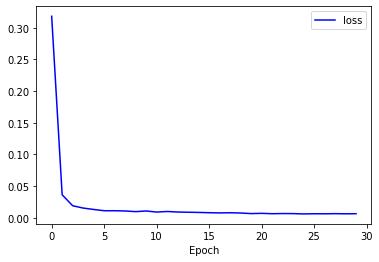

In [10]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# test_x_array 각 샘플의 2시간 예측값이 기록되어 있는 test_pred_array shape 확인
print(test_pred_array.shape)

In [13]:
# 매수 시점, 매수 비율 표 만들기
# 1) train_pred_array 3차원에서 2차원으로 바꾸기
pred_array_2d = np.zeros([test_pred_array.shape[0], 120])

for idx in tqdm(range(test_pred_array.shape[0])):
    pred_array_2d[idx, :] = test_pred_array[idx, :, 0]

# 2) 예측값을 재해석하여 submission 표를 작성하는 함수 정의
def array_to_submission(pred_array):
    submission = pd.DataFrame(np.zeros([pred_array.shape[0], 2], np.int64),
                              columns=['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis=1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    submission.loc[:, 'buy_quantity'] = ((1*1*(sell_price/1)*0.9995*0.9995) > 1.08)
    submission['sell_time'] = np.argmax(pred_array, axis=1)
    submission.columns = ['sample_id', 'buy_quantity', 'sell_time']
    return submission, sell_price

final_submission, forcasted_max = array_to_submission(pred_array_2d)

100%|██████████| 529/529 [00:00<00:00, 83422.45it/s]


NameError: ignored

In [ ]:
# 각 샘플의 예측치 중 최고값 모아 보기
forcasted_max

In [ ]:
# 전체 300가지 sample에 대해 _가지 case에서 108% 이상 상승한다고 추론함.
final_submission.buy_quantity.value_counts()

In [ ]:
# final_submission csv파일로 저장
final_submission.to_csv('./submission.csv', index = False)

In [ ]:
# 모델 평가: test_x데이터로 예측하는 방식을 입력값(train_x)에 대한 예측값과 실제값(train_y_array) 비교를 통해 평가

train_pred_array = np.zeros([1, 120, 1])

sample = 100  #평가용 임의의 샘플 id

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10, mode = 'auto')

# train_x_array데이터로 시계열 Windows 만들기
# idx에 해당하는 샘플 하나만 학습하므로 for loop는 한 번만 돌아감
for idx in range(sample, sample+1):
    seq_len = 120
    sequence_length = seq_len + 1

    windows = []
    for index in range(1380 - sequence_length):
        windows.append(train_x_array[idx, :, 1][index: index + sequence_length])

    # x_train, y_train 데이터 구성
    windows = np.array(windows) #1329 * 121의 2차원 배열
    x_train = windows[:, :-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = windows[:, -1]

    
    # Fit(early_stoppage & reduceLR 적용)
    model = build_model()
    history = model.fit(x_train, y_train, validation_split=0.1, epochs = ep, batch_size = bs, verbose = 2, callbacks = [early_stop])

    # train_x_array Windows 중 마지막 윈도우 추출해서 3차원 변환시켜 LSTM모델에 넣고 Predict
    window = windows[-1, :-1]
    window_3d = np.reshape(window, (1, window.shape[0], 1))
    for m in range(window.shape[0]):
        # model.predict()에 window_3d 넣어 예측
        pred = model.predict(window_3d)
        # 120분 중 처음 1분 예측값 train_pred_array에 기록
        train_pred_array[:, m, :] = pred
        # window_3d의 첫번째 분 값은 삭제한 window_3d_2nd 구성
        window_3d_2nd = window_3d[0, 1:, :]  # 119개
        # pred_target(prediction할 때마다 나오는 각각의 예측값들) 1차원 -> 2차원으로 구성
        pred_target = train_pred_array[:, m, :]
        pred_target = np.reshape(pred_target, (pred_target.shape[0], 1))
        # train_pred_array와 window_3d_2nd 병합하여 모델에 입력할 새로운 window_3d 재구성
        window_3d = np.concatenate((window_3d_2nd, pred_target), axis=0)
        window_3d = window_3d.T
        window_3d = np.reshape(window_3d, (window_3d.shape[0], window_3d.shape[1], 1))

In [ ]:
# train 샘플 훈련 성과 시각화해보기
# 1) 입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 정의
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

# 2) train data 중 sample_id idx에 해당하는 x_series로 모델을 학습한 후 y_series를 추론
x_series = train_x_array[sample,:,1]
y_series = train_y_array[sample,:,1]
plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), train_pred_array[0,:,0], label = 'prediction')
plt.legend()
plt.show()

In [ ]:
# 손실값 시각화
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()